# Download Data #

In [6]:
#download kaggle data
!kaggle competitions download -c customer-churn-prediction-2020 --force



  0%|          | 0.00/154k [00:00<?, ?B/s]
100%|██████████| 154k/154k [00:00<00:00, 2.60MB/s]


# Imports #

In [3]:
from sklearn.model_selection import train_test_split # train test split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix # classification scoring
from sklearn.model_selection import GridSearchCV # parameter tuning

import pandas as pd 
import numpy as np

import xgboost as xgb

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("training data shape: ",train.shape)
print("test data shape: ",test.shape)

training data shape:  (4250, 20)
test data shape:  (750, 20)


# Process data #

In [5]:
train.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

In [8]:
# Check for missing values
print(train.columns[train.isnull().any()].tolist())
print(test.columns[test.isnull().any()].tolist())

[]
[]


In [32]:
#split features and targets
X = train.drop('churn', axis=1).copy() 
y = train['churn'].copy()

In [11]:
print(X.state.unique())

['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']


In [33]:
print(X.state.unique())
print(X.area_code.unique())
print(X.international_plan.unique())
print(X.voice_mail_plan.unique())

['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
['area_code_415' 'area_code_408' 'area_code_510']
['no' 'yes']
['yes' 'no']


In [34]:
# Object to Binary Labels
X['international_plan'] = np.where(X['international_plan'].str.contains('yes'), 1, 0) # Note that 'no' is 1 to keep consistent with the data dictionary
X['voice_mail_plan'] = np.where(X['voice_mail_plan'].str.contains('yes'), 1, 0)
test['international_plan'] = np.where(test['international_plan'].str.contains('yes'), 1, 0)
test['voice_mail_plan'] = np.where(test['voice_mail_plan'].str.contains('yes'), 1, 0)


In [14]:
X.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3


In [35]:
# Add Dummy Variable
X = pd.get_dummies(X, columns=['state', 'area_code'])
test = pd.get_dummies(test, columns=['state', 'area_code'])

In [36]:
X.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,0,0,0,0,0,0,0,0,1,0
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,0,0,0,0,0,0,0,0,1,0
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,0,0,0,0,0,0,0,1,0,0
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,0,0,0,0,0,0,0,0,1,0
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,...,0,0,0,0,0,0,0,0,0,1


In [19]:
#y = pd.Series(np.where(y == 'yes', 1, 0),y.index)

In [20]:
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int32

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, stratify=y)

# Modelling #

In [40]:
#Running GridSearchCV in sequential manner to speed up hyperparameter tuning

#1
param_grid = {
     'max_depth': [3, 4, 5],
     'learning_rate': [0.1, 0.01, 0.05],
     'gamma': [0, 0.25, 1.0],
     'reg_lambda': [0, 1.0, 10.0],
     'scale_pos_weight': [1, 3, 5]
}

#2
param_grid = {
     'max_depth': [4],
     'learning_rate': [0.1, 0.5, 1],
     'gamma': [0.25],
     'reg_lambda': [10.0, 20, 100],
      'scale_pos_weight': [1]
}

optimal_params = GridSearchCV(
     estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                 seed=42,
                                 subsample=0.95,
                                 colsample_bytree=0.5),
     param_grid=param_grid,
     scoring='roc_auc', ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
     verbose=0, # NOTE: set verbose=2 to see Gridsearch report
     n_jobs = 10,
     cv = 3
 )

optimal_params.fit(X_train, 
                    y_train, 
                    early_stopping_rounds=10,                
                    eval_metric='auc',
                    eval_set=[(X_test, y_test)],
                    verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


In [41]:
# Evaluate Optimized Model
clf_xgb = xgb.XGBClassifier(seed=11,
                        objective='binary:logistic',
                        gamma=0.25,
                        learn_rate=0.01,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=1,
                        subsample=0.95,
                        colsample_bytree=0.5)

clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[20:15:43] WARNING: D:\Build\xgboost\xgboost-1.2.1.git\src\learner.cc:516: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.56267
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.62336
[2]	validation_0-aucpr:0.72774
[3]	validation_0-aucpr:0.77370
[4]	validation_0-aucpr:0.78095
[5]	validation_0-aucpr:0.78656
[6]	validation_0-aucpr:0.78771
[7]	validation_0-aucpr:0.78271
[8]	validation_0-aucpr:0.79666
[9]	validation_0-aucpr:0.80761
[10]	validation_0-aucpr:0.81012
[11]	validation_0-aucpr:0.81093
[12]	validation_0-aucpr:0.81383
[13]	validation_0-aucpr:0.81664
[14]	validation_0-aucpr:0.81552
[15]	validation_0-aucpr:0.81937
[16]	validation_0-aucpr:0.82258
[17]	validation_0-aucpr:0.82467
[18]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.01, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=11, subsample=0.95, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [42]:
preds = clf_xgb.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost Final prediction accuracy with hyperparameters tuned: %3.2f" % (accuracy))

XGBoost Final prediction accuracy with hyperparameters tuned: 95.01


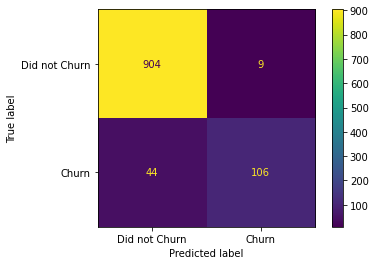

In [43]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not Churn", "Churn"])

In [45]:
predictor_cols

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'state_AK',
       'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN',
       'state_TX', 'state_U

# Creating Submission File #

In [49]:
predictor_cols = X_test.columns
# Make predictions
predicted = clf_xgb.predict(test[predictor_cols])
predicted[:10]

array(['no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'yes'],
      dtype=object)